# 1. Image Transformation and Stitching

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# Load the images
image1 = cv2.imread("1.jpeg")
image2 = cv2.imread("2.jpeg")
image3 = cv2.imread("3.jpeg")
# Convert the images to RGB
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)


## Manual Identification
- We use predefined points for feature identification, which were generated in advance. If needed, you can run the `selection_identification.py` script to manually select points for feature identification.

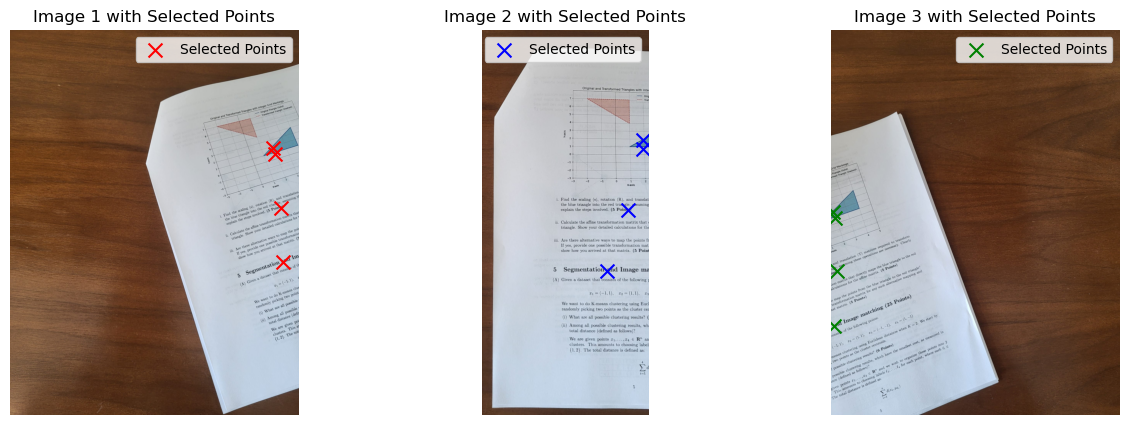

In [4]:

# Convert images from BGR (OpenCV default) to RGB for displaying in matplotlib
img1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

# Step 3: Predefined points for feature identification
points_img1 = np.array([
    (1364.76, 611.51),
    (1376.12, 645.60),
    (1406.97, 923.20),
    (1416.71, 1205.67)
])
points_img2 = np.array([
    (860.41, 584.64),
    (860.41, 631.19),
    (777.29, 957.01),
    (665.92, 1279.50)
])
points_img3 = np.array([
    (14.11, 945.93),
    (20.60, 975.15),
    (30.34, 1252.75),
    (17.36, 1536.84)
])

# Step 4: Display images with the selected points
plt.figure(figsize=(15, 5))

# Image 1 with points
plt.subplot(1, 3, 1)
plt.imshow(img1_rgb)
plt.scatter(points_img1[:, 0], points_img1[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title("Image 1 with Selected Points")
plt.axis('off')
plt.legend()

# Image 2 with points
plt.subplot(1, 3, 2)
plt.imshow(img2_rgb)
plt.scatter(points_img2[:, 0], points_img2[:, 1], c='blue', marker='x', s=100, label='Selected Points')
plt.title("Image 2 with Selected Points")
plt.axis('off')
plt.legend()

# Image 3 with points
plt.subplot(1, 3, 3)
plt.imshow(img3_rgb)
plt.scatter(points_img3[:, 0], points_img3[:, 1], c='green', marker='x', s=100, label='Selected Points')
plt.title("Image 3 with Selected Points")
plt.legend()
plt.axis('off')
plt.show()


## Automated Detection

#### Feature Detection and Description Function
- This function detects and describes features in an image using either SIFT or ORB.
- It returns the keypoints and their corresponding feature descriptors.

In [5]:
def detectAndDescribe(image, method=None):
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

#### Create and return a Matcher Object

In [6]:
def createMatcher(method,crossCheck):

    if method == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

#### Matcher Creation Function
- This function creates and returns a brute-force matcher object based on the selected method (SIFT or ORB).
- It configures the matcher to use the appropriate distance metric and cross-checking setting.

In [7]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
    best_matches = bf.match(featuresA,featuresB)
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    return rawMatches

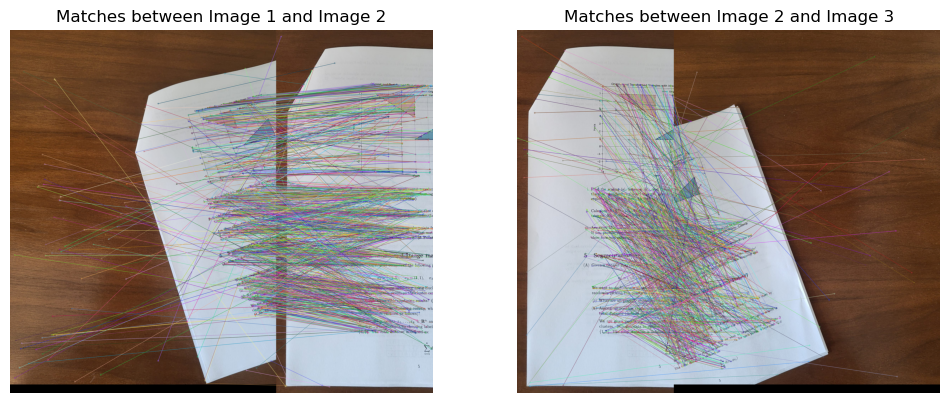

In [8]:
# Detect and describe the features
kps1, features1 = detectAndDescribe(image1, method='sift')
kps2, features2 = detectAndDescribe(image2, method='sift')
kps3, features3 = detectAndDescribe(image3, method='sift')

# Match the features
matches12 = matchKeyPointsBF(features1, features2, method='sift')
matches23 = matchKeyPointsBF(features2, features3, method='sift')

# Draw the matches
img_matches12 = cv2.drawMatches(image1, kps1, image2, kps2, matches12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches23 = cv2.drawMatches(image2, kps2, image3, kps3, matches23, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Matches between Image 1 and Image 2")
plt.imshow(cv2.cvtColor(img_matches12, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Matches between Image 2 and Image 3")
plt.imshow(cv2.cvtColor(img_matches23, cv2.COLOR_BGR2RGB)) 
plt.axis('off')
plt.show()


#### Homography Computation Function
- This function computes the homography matrix that transforms points from one image to another.
- It uses RANSAC (Random Sample Consensus) to robustly estimate the homography by finding the best match
- between points while rejecting outliers based on a reprojection threshold.

In [9]:
# define a function to compute the homography matrix
def getHomography(kpsA, kpsB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # RANSAC
        bestH = None
        bestStatus = None
        maxInliers = 0
        iterations =5500  # Maximum number of iterations for RANSAC

        for _ in range(iterations):
            # Randomly select 4 point pairs
            sample_indices = random.sample(range(len(ptsA)), 4)
            sample_ptsA = ptsA[sample_indices]
            sample_ptsB = ptsB[sample_indices]
            
            # Compute homography from these 4 points
            H = computeHomography(sample_ptsA, sample_ptsB)
            if H is None:
                continue
            
            # Compute the reprojection error for all points
            projected_ptsB = np.dot(H, np.hstack((ptsA, np.ones((ptsA.shape[0], 1)))).T).T
            projected_ptsB = projected_ptsB[:, :2] / projected_ptsB[:, 2].reshape(-1, 1)  # Convert to homogeneous coordinates
            
            # Compute the reprojection errors
            errors = np.linalg.norm(projected_ptsB - ptsB, axis=1)
            
            # Find inliers based on the threshold
            status = errors < reprojThresh
            num_inliers = np.sum(status)
            
            # Keep track of the best homography with the maximum inliers
            if num_inliers > maxInliers:
                maxInliers = num_inliers
                bestH = H
                bestStatus = status

        if bestH is not None:
            return (matches, bestH, bestStatus)
        else:
            return None
    else:
        return None


def computeHomography(ptsA, ptsB):
    """ Compute the homography matrix given four point correspondences """
    if len(ptsA) != 4 or len(ptsB) != 4:
        return None
    
    A = []
    for i in range(4):
        xA, yA = ptsA[i]
        xB, yB = ptsB[i]
        A.append([-xA, -yA, -1, 0, 0, 0, xA * xB, yA * xB, xB])
        A.append([0, 0, 0, -xA, -yA, -1, xA * yB, yA * yB, yB])
    
    A = np.array(A)
    
    # Solve for the homography matrix using SVD
    _, _, V = np.linalg.svd(A)
    h = V[-1]
    
    # Reshape to get the homography matrix
    H = h.reshape(3, 3)
    return H


#### the function of cutting the black part of the image

In [10]:
def cutBlack(pic): # cut the black part of the image
    rows, cols = np.where(pic[:,:,0] !=0)
    min_row, max_row = min(rows), max(rows) +1
    min_col, max_col = min(cols), max(cols) +1
    return pic[min_row:max_row,min_col:max_col,:]

#### Main function for feature detection, matching, homography estimation, and image stitching
-  This function performs feature detection, feature matching, computes the homography matrix,
- and stitches two images together. The `feature_extractor` parameter allows selection of
- the feature extraction method (SIFT by default).

In [11]:
def swap(a, b): # swap the image
    return b,a

def handle(path1, path2, feature_extractor='sift'):
    # define the feature extractor and feature matching method
    if isinstance(path2,str):
        imageA = cv2.imread(path2)
        imageA = cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB)
    else:
        imageA = path2
    imageA_gray = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
    if isinstance(path1,str):
        imageB = cv2.imread(path1)
        imageB = cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB)
    else:
        imageB = path1
    t = np.size(imageB)
    imageB_gray = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)
    # detect and describe features
    kpsA, featuresA = detectAndDescribe(imageA_gray, method=feature_extractor)
    kpsB, featuresB = detectAndDescribe(imageB_gray, method=feature_extractor)

    # match features
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(imageA,kpsA,imageB,kpsB,matches[:100],
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # find homography matrix
    matchCount = len(matches)
    M = getHomography(kpsA, kpsB, matches, reprojThresh=3)
    if M is None:
        print("Error!")
    (matches, H, status) = M
    
    # warp perspective
    result = cv2.warpPerspective(imageA, H, ((imageA.shape[1] + imageB.shape[1])*2, (imageA.shape[0] + imageB.shape[0]) * 2))
    resultAfterCut = cutBlack(result)
    
    # # check the loaction of the image
    if np.size(resultAfterCut) < np.size(imageA) * 0.95:
        # swap the image
        kpsA,kpsB = swap(kpsA, kpsB)
        imageA, imageB = swap(imageA, imageB)
        matches = matchKeyPointsBF(featuresB, featuresA, method=feature_extractor)
        matchCount = len(matches)
        M = getHomography(kpsA, kpsB, matches, reprojThresh=3)
        if M is None:
            print("Error!")
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H, ((imageA.shape[1] + imageB.shape[1])*2, (imageA.shape[0] + imageB.shape[0]) * 2))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = np.maximum(imageB, result[0:imageB.shape[0], 0:imageB.shape[1]]) 
    result = cutBlack(result)
    return result, matchCount

def handleMulti(*args):
    l = len(args)
    assert(l > 1)
    isHandle = [0 for i in range(l - 1)]
    nowPic = args[0]
    args = args[1:]
    for j in range(l - 1):
        isHas = False
        matchCountList = []
        resultList = []
        indexList = []
        for i in range(l - 1):
            if (isHandle[i] == 1):
                continue
            result, matchCount = handle(nowPic, args[i])
            plt.imshow(result)
            plt.axis('off')
            plt.show()
            if not result is None:
                matchCountList.append(matchCount)
                resultList.append(result)
                indexList.append(i)
                isHas = True
        if not isHas:
            return None
        else:
            index = matchCountList.index(max(matchCountList))
            nowPic = resultList[index]
            isHandle[indexList[index]] = 1
    return nowPic

#### show wrapped images step by step

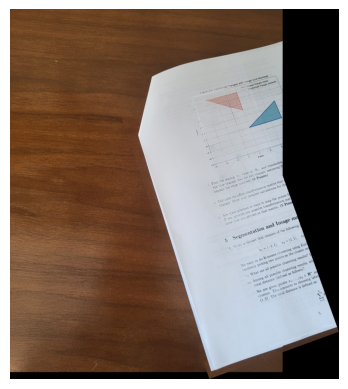

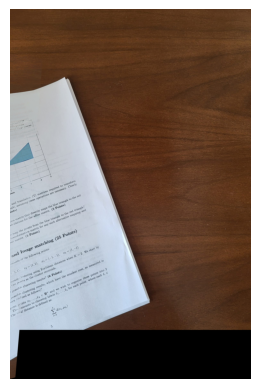

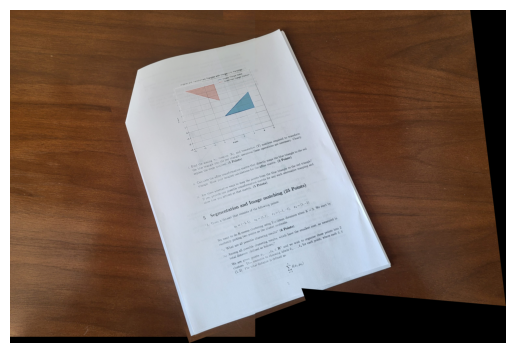

In [12]:
result = handleMulti("1.jpeg", "2.jpeg","3.jpeg")

#### display the result
-  Check if the result is good. If not, run again

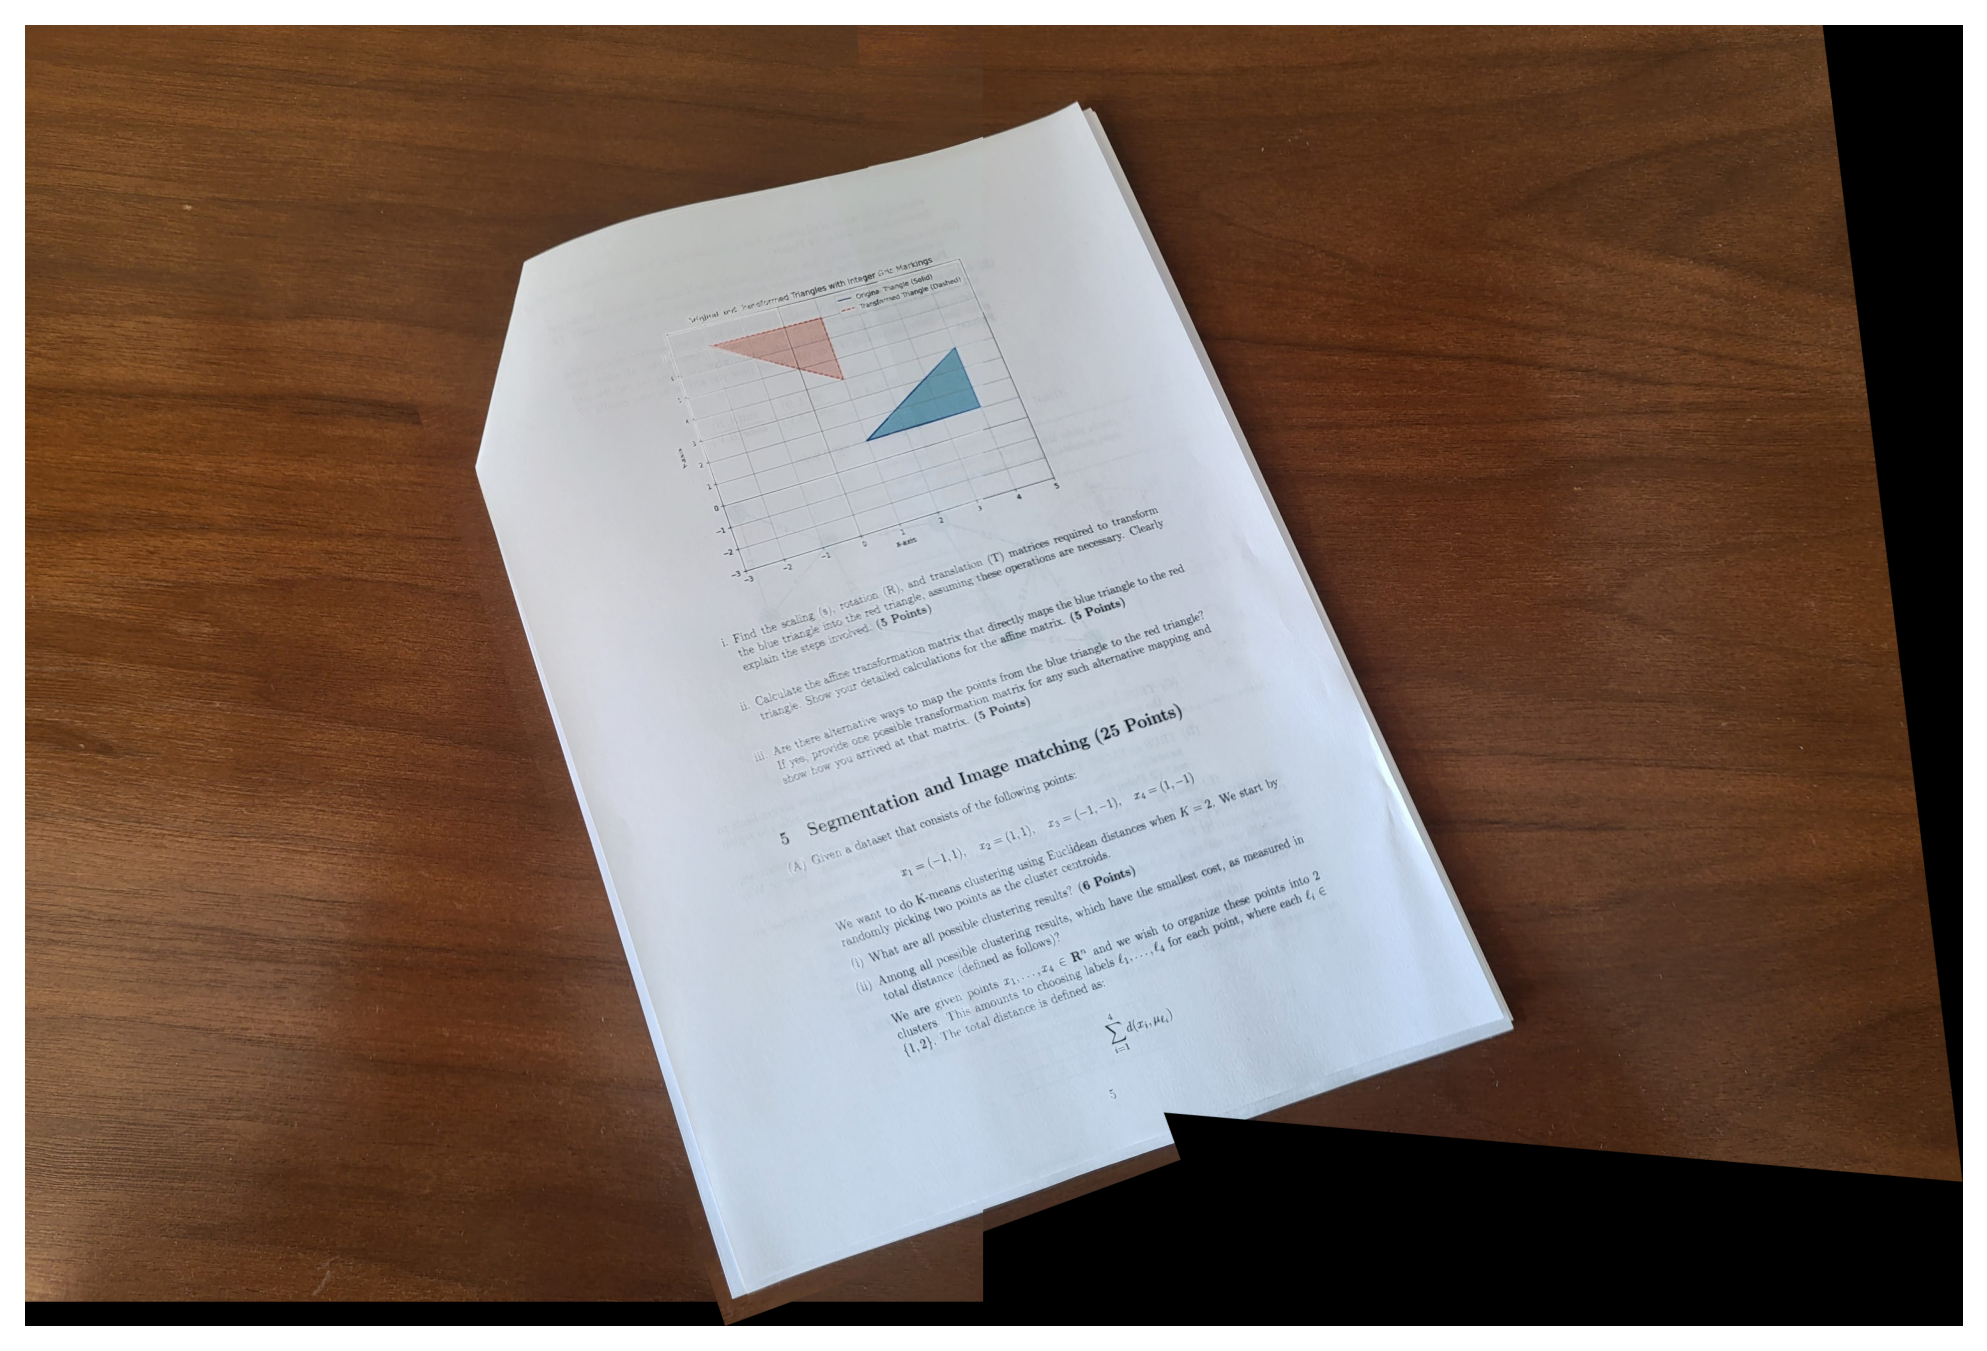

In [13]:
plt.figure(figsize=(10, 10), dpi=250)
plt.imshow(result)
plt.axis('off')
plt.show()

#### Comparison
 SIFT is efficient for large datasets, but manual matching is more accurate for specific, hard-to-detect features. The choice of method depends on the project requirements and the nature of the images being processed.

# 2. Hough Transform